In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os, sys

import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import yaml
import scipy
import numpy as np
import pandas as pd

import plotly
plotly.io.kaleido.scope.mathjax = None

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

proj_root = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(proj_root)

from minatar import Environment

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import apply_redo_parametrization

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

For each checkpoint of an experiment we want to prune with different pruning factors and compare against different thresholds + redo scores

In [30]:
# Collect all paths to models in a specified folder
file_dir = os.path.dirname(os.path.abspath("."))
training_outputs_folder_path = os.path.join(proj_root, "experiments", "training", "outputs")
pruning_outputs_folder_path = os.path.join(file_dir, "outputs")
training_timestamp_folder = "2023_05_22-08_44_19"

experiments_folder = os.path.join(training_outputs_folder_path, training_timestamp_folder)

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

for exp in experiment_paths:
    exp["models_folder_path"] = os.path.dirname(exp["model_path"])


In [31]:
experiment_paths[0]

{'model_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\model_checkpoints\\mck_25',
 'training_folder_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0',
 'config_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\conv16_lin64_asterix_0_config',
 'stats_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\conv16_lin64_asterix_0_train_stats',
 'models_folder_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\model_checkpoints'}

In [32]:
with open(experiment_paths[0]["config_path"], "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

cfg

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 200000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 125000}},
 'environment': 'asterix',
 'epochs_to_train': 25,
 'estimator': {'args_': {'conv_hidden_out_size': 16,
   'lin_hidden_out_size': 64},
  'model': 'Conv_QNET'},
 'experiment_name': 'conv16_lin64_asterix_0',
 'experiment_output_folder': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0',
 'experiment_start_timestamp': '2023_05_22-08_44_19',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'path_experiments_outputs': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs',
 'redo': {'beta': 0.1, 'enabled': True, 'tau': 

In [33]:
### Testing stuff

In [34]:
def get_rankings(scores):
    sorted_indices = torch.argsort(scores)

    # Initialize tensor for rankings
    rankings = torch.zeros_like(scores, dtype=torch.long)

    # Assign ranks to scores
    rankings[sorted_indices] = torch.arange(1, len(scores) + 1)

    return rankings

exp_paths = experiment_paths[0]

training_stats_data = torch.load(exp_paths["stats_path"])
redo_scores = training_stats_data["redo_scores"]["policy"]

checkpoints_paths = search_files_containing_string(
    exp_paths["models_folder_path"], "mck", substring_location="containing"
)

# read the config so that the model architecture can be loaded
with open(exp_paths["config_path"], "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

results = []
for checkpoint_path in checkpoints_paths:
    
    # Build a new model
    validation_env = build_environment(
        cfg["environment"], cfg["seed"]
    )

    # returns state as [w, h, channels]
    state_shape = validation_env.observation_space.shape

    # permute to get batch, channel, w, h shape
    # specific to minatar
    in_features = (state_shape[2], state_shape[0], state_shape[1])
    in_channels = in_features[0]
    num_actions = validation_env.action_space.n

    checkpoint_model = Conv_QNET(in_features = in_features, 
                                in_channels = in_channels, 
                                num_actions = num_actions, 
                                **cfg["estimator"]["args_"])
    checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)

    # Get the state of the model
    checkpoint_models_state = torch.load(checkpoint_path)
    checkpoint_model.load_state_dict(checkpoint_models_state["policy_model_state_dict"])
    model_state = checkpoint_model.state_dict()

    # Compute kendall rank correlation coefficient for each layer
    layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
    for i, layer_key in enumerate(layer_weight_keys):
        weights = model_state[layer_key]

        # compute the weight of the neurons in this layer
        if weights.dim() > 2:
            l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
        else:
            l1_norms = torch.sum(torch.abs(weights), dim=(1))

        neuron_rankings = get_rankings(l1_norms)
        
        check_index = int(os.path.basename(checkpoint_path).split("_")[1]) - 1 # get the index of the checkpoint
        
        redo_score = redo_scores[check_index][i]
        redo_rankings = get_rankings(torch.tensor(redo_score))

        k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
        s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
        p_corr, p_pval = scipy.stats.pearsonr(l1_norms, redo_score)

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning:

WARN: The environment MinAtar/Asterix-v0 is out of date. You should consider upgrading to version `v1`.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning:

WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning:

WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_32268\4204159576.py:69: UserWarning:

To copy construct from a 

In [35]:


# Create scatter plot
fig = go.Figure(data=go.Scatter(x=l1_norms, y=redo_score, mode='markers'))

# Add labels and title
fig.update_layout(
    title='Scatter Plot',
    xaxis_title='Tensor 1',
    yaxis_title='Tensor 2'
)

# Display the plot
fig.show()

In [36]:


# Create scatter plot
fig = go.Figure(data=go.Scatter(x=neuron_rankings, y=redo_rankings, mode='markers'))

# Add labels and title
fig.update_layout(
    title='Scatter Plot',
    xaxis_title='Tensor 1',
    yaxis_title='Tensor 2'
)

# Display the plot
fig.show()

In [37]:
# l1_norms, neuron_rankings
# redo_score, redo_rankings

corr, pval = scipy.stats.pearsonr(l1_norms, redo_score)
print(corr, pval)
corr, pval = scipy.stats.spearmanr(l1_norms, redo_score)
print(corr, pval)

corr, pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
print(corr, pval)
corr, pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
print(corr, pval)

0.18676006079210986 0.13949640454302953
0.35214106716702975 0.004322370105034088
0.2648809523809524 0.0019761448374365966
0.3518315018315018 0.0043589997313975065


In [38]:
t = torch.tensor([10, 9, 2, 1, 3])
torch.argsort(t)

t[torch.argsort(t)]

rankings = torch.zeros_like(torch.argsort(t))

# Assign ranks to scores
rankings[torch.argsort(t)] = torch.arange(1, len(torch.argsort(t)) + 1)
rankings

tensor([5, 4, 2, 1, 3])

In [39]:
torch.argsort(t)

tensor([3, 2, 4, 1, 0])

In [40]:
def mask_to_score_distance(mask, scores):
    num_ones = np.count_nonzero(mask)

    if num_ones == 0:
        return 0
    
    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)
    
    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True
     
    # Calculate the Hamming distance between the masks
    hamming_distance = torch.sum(torch.logical_and(mask, new_mask))
    hamming_relative_distance = hamming_distance.item() / len(mask)

    return hamming_relative_distance

def mask_vs_norm_stats(mask, scores):
    num_ones = np.count_nonzero(mask)
    
    # Sort the scores in ascending order and get their corresponding indices
    sorted_indices = np.argsort(scores)
    
    # Create a new mask where the N smallest values represent True
    new_mask = torch.zeros_like(mask, dtype=torch.bool)
    new_mask[sorted_indices[:num_ones]] = True
     
    # Calculate the Hamming distance between the masks
    only_redo = torch.sum(torch.logical_and(mask, torch.eq(new_mask, False))).item() 
    intersect = torch.sum(torch.logical_and(mask, new_mask)).item() 
    only_pruning = torch.sum(torch.logical_and(torch.eq(mask, False), new_mask)).item()

    return only_redo, intersect, only_pruning

def get_rankings(scores):
    sorted_indices = torch.argsort(scores)

    # Initialize tensor for rankings
    rankings = torch.zeros_like(scores, dtype=torch.long)

    # Assign ranks to scores
    rankings[sorted_indices] = torch.arange(1, len(scores) + 1)

    return rankings

def compare_redo_pruning(exp_paths):

    training_stats_data = torch.load(exp_paths["stats_path"])
    redo_scores = training_stats_data["redo_scores"]["policy"]

    checkpoints_paths = search_files_containing_string(
        exp_paths["models_folder_path"], "mck", substring_location="containing"
    )

    # read the config so that the model architecture can be loaded
    with open(exp_paths["config_path"], "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)

    results = []
    for checkpoint_path in checkpoints_paths:
        
        # Build a new model
        validation_env = build_environment(
            cfg["environment"], cfg["seed"]
        )

        # returns state as [w, h, channels]
        state_shape = validation_env.observation_space.shape

        # permute to get batch, channel, w, h shape
        # specific to minatar
        in_features = (state_shape[2], state_shape[0], state_shape[1])
        in_channels = in_features[0]
        num_actions = validation_env.action_space.n

        checkpoint_model = Conv_QNET(in_features = in_features, 
                                    in_channels = in_channels, 
                                    num_actions = num_actions, 
                                    **cfg["estimator"]["args_"])
        checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)

        # Get the state of the model
        checkpoint_models_state = torch.load(checkpoint_path)
        checkpoint_model.load_state_dict(checkpoint_models_state["policy_model_state_dict"])
        model_state = checkpoint_model.state_dict()

        # Compute kendall rank correlation coefficient for each layer
        layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
        for i, layer_key in enumerate(layer_weight_keys):
            weights = model_state[layer_key]

            # compute the weight of the neurons in this layer
            if weights.dim() > 2:
                l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            else:
                l1_norms = torch.sum(torch.abs(weights), dim=(1))

            neuron_rankings = get_rankings(l1_norms)
        
            check_index = int(os.path.basename(checkpoint_path).split("_")[1]) - 1 # get the index of the checkpoint
            
            redo_score = redo_scores[check_index][i]
            redo_rankings = get_rankings(torch.tensor(redo_score))

            k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
            s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
            p_corr, p_pval = scipy.stats.pearsonr(l1_norms, redo_score)

            # also do an experiment with thresholding  

            tau_vals = [0.025, 0.1]

            for tau in tau_vals:
                dormant_neurons_mask = (redo_score <= tau)
                
                dormant_neurons_idx = dormant_neurons_mask.nonzero().flatten()

                only_redo, intersect, only_pruning = mask_vs_norm_stats(
                    dormant_neurons_mask, l1_norms
                )

                new_row = {"seed": cfg["seed"],
                        "env": cfg["environment"],
                        "experiment": "_".join(cfg["experiment_name"].split("_")[:2]), # WARNING
                        "tau": tau,
                        "nr_only_redo": only_redo,
                        "nr_intersect": intersect,
                        "nr_only_pruning": only_pruning,
                        "dead_neuron_l1norms": l1_norms[dormant_neurons_idx],
                        "dead_neuron_l1norms_avg": np.average(l1_norms[dormant_neurons_idx]),
                        "dead_neuron_ratio": len(dormant_neurons_idx) / len(redo_score),
                        "redo_l1norm_hamming": mask_to_score_distance(dormant_neurons_mask, l1_norms),
                        "checkpoint": os.path.basename(checkpoint_path),
                        "epoch": check_index, 
                        "layer": layer_key,
                        "kendall_r_corr": k_corr, 
                        "kendall_r_pval": k_pval,
                        "spearman_r_corr": s_corr, 
                        "spearman_r_pval": s_pval,
                        "pearson_corr": p_corr, 
                        "pearson_pval": p_pval
                        }
                results.append(new_row)

    df = pd.DataFrame(results)

    return df 
    

In [41]:
exp_analysis_results = []

for exp_paths in experiment_paths:
    exp_analysis_results.append(compare_redo_pruning(exp_paths))

# concatenate the dataframes vertically
df_res = pd.concat(exp_analysis_results)
df_res

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_32268\464247714.py:105: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning:

WARN: The environment MinAtar/Asterix-v0 is out of date. You should consider upgrading to version `v1`.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning:

WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning:

WARN: It seems a Box observation space is an image but the upper and lower bo

seed             env    experiment    tau  nr_only_redo  nr_intersect  \
0       0         asterix  conv16_lin64  0.025             3             4   
1       0         asterix  conv16_lin64  0.100             2            10   
2       0         asterix  conv16_lin64  0.025             2             2   
3       0         asterix  conv16_lin64  0.100             3             8   
4       0         asterix  conv16_lin64  0.025             1            45   
..    ...             ...           ...    ...           ...           ...   
145     1  space_invaders   conv8_lin32  0.100             1             2   
146     1  space_invaders   conv8_lin32  0.025             1             0   
147     1  space_invaders   conv8_lin32  0.100             2             3   
148     1  space_invaders   conv8_lin32  0.025             3            17   
149     1  space_invaders   conv8_lin32  0.100             2            28   

     nr_only_pruning                                dead_neuron_l1norms  \
0                  3  [tensor(3.3978), tensor(2.9052), tensor(3.8876...   
1                  2  [tensor(3.3978), tensor(2.9052), tensor(3.6997...   
2                  2  [tensor(7.4492), tensor(8.2096), tensor(6.0271...   
3                  3  [tensor(8.8033), tensor(8.1095), tensor(7.4492...   
4                  1  [tensor(12.2215), tensor(12.0013), tensor(12.1...   
..               ...                                                ...   
145                1   [tensor(8.6357), tensor(7.8074), tensor(7.6687)]   
146                1                                  [tensor(10.5037)]   
147                2  [tensor(9.0654), tensor(11.7338), tensor(10.50...   
148                3  [tensor(8.4035), tensor(30.2413), tensor(22.54...   
149                2  [tensor(8.4035), tensor(21.5228), tensor(30.24...   

     dead_neuron_l1norms_avg  dead_neuron_ratio  redo_l1norm_hamming  \
0                   3.711692            0.43750             0.250000   
1                   3.808709            0.75000             0.625000   
2                   6.731621            0.25000             0.125000   
3                   7.831610            0.68750             0.500000   
4                  12.138257            0.71875             0.703125   
..                       ...                ...                  ...   
145                 8.037274            0.37500             0.250000   
146                10.503723            0.12500             0.000000   
147                 9.368734            0.62500             0.375000   
148                15.201574            0.62500             0.531250   
149                17.480595            0.93750             0.875000   

    checkpoint  epoch              layer  kendall_r_corr  kendall_r_pval  \
0        mck_1      0  features.0.weight        0.350000    6.411343e-02   
1        mck_1      0  features.0.weight        0.350000    6.411343e-02   
2        mck_1      0  features.2.weight        0.183333    3.501953e-01   
3        mck_1      0  features.2.weight        0.183333    3.501953e-01   
4        mck_1      0        fc.0.weight        0.588294    6.364803e-12   
..         ...    ...                ...             ...             ...   
145      mck_9      8  features.0.weight        0.642857    3.115079e-02   
146      mck_9      8  features.2.weight        0.071429    9.048611e-01   
147      mck_9      8  features.2.weight        0.071429    9.048611e-01   
148      mck_9      8        fc.0.weight        0.600806    2.423272e-07   
149      mck_9      8        fc.0.weight        0.600806    2.423272e-07   

     spearman_r_corr  spearman_r_pval  pearson_corr  pearson_pval  
0           0.450000     8.029574e-02      0.473772  6.376420e-02  
1           0.450000     8.029574e-02      0.473772  6.376420e-02  
2           0.244118     3.622135e-01      0.286141  2.826493e-01  
3           0.244118     3.622135e-01      0.286141  2.826493e-01  
4           0.747848     1.242029e-12      0.9424

In [42]:
# big TODO
# Experiment 1: Set a threshold -> computed to select nr of dead neurons
# Compute pruning indexes. Compute huffman distance or simillar
# Do this as we advance through training

# Experiment 2: set a threshold
# Find the dead neurons and compute l1 norm of neurons
# plot the l1 norms through training

# use tau = 0.1 for finding dead neurons
# histogram of the l1 norm of dead neurons during training

In [43]:

mask = torch.tensor([False, False, True])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)
mask_vs_norm_stats(mask, scores)

(1, 0, 1)

In [44]:

mask = torch.tensor([True, False, False])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)
mask_vs_norm_stats(mask, scores)


(0, 1, 0)

In [45]:

mask = torch.tensor([True, True, False])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)

0.6666666666666666

In [46]:

mask = torch.tensor([True, False, True])
scores = [0, 1, 2]

    
mask_to_score_distance(mask, scores)
mask_vs_norm_stats(mask, scores)


(1, 1, 1)

In [47]:
cfg

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 200000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 125000}},
 'environment': 'asterix',
 'epochs_to_train': 25,
 'estimator': {'args_': {'conv_hidden_out_size': 16,
   'lin_hidden_out_size': 64},
  'model': 'Conv_QNET'},
 'experiment_name': 'conv16_lin64_asterix_0',
 'experiment_output_folder': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0',
 'experiment_start_timestamp': '2023_05_22-08_44_19',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'path_experiments_outputs': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs',
 'redo': {'beta': 0.1, 'enabled': True, 'tau': 

In [48]:
df_res.columns

Index(['seed', 'env', 'experiment', 'tau', 'nr_only_redo', 'nr_intersect',
       'nr_only_pruning', 'dead_neuron_l1norms', 'dead_neuron_l1norms_avg',
       'dead_neuron_ratio', 'redo_l1norm_hamming', 'checkpoint', 'epoch',
       'layer', 'kendall_r_corr', 'kendall_r_pval', 'spearman_r_corr',
       'spearman_r_pval', 'pearson_corr', 'pearson_pval'],
      dtype='object')

Text(0.5, 0.98, 'dead_neuron_l1norms_avg')

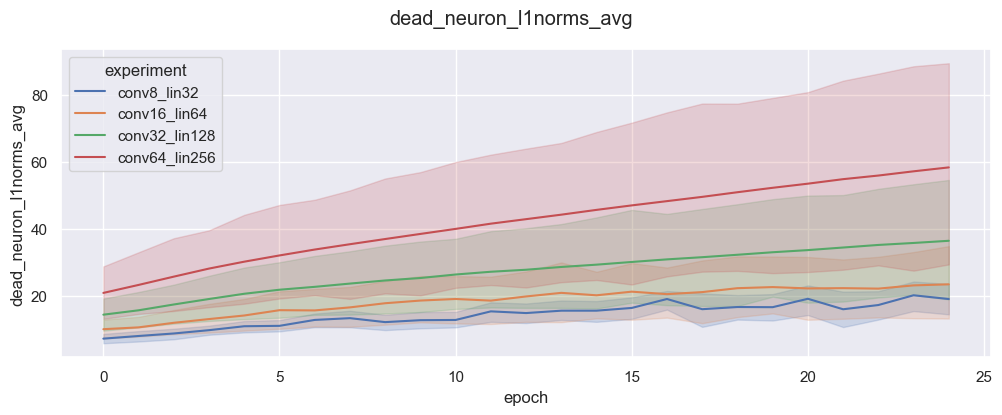

In [49]:
metric_col = 'dead_neuron_l1norms_avg'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

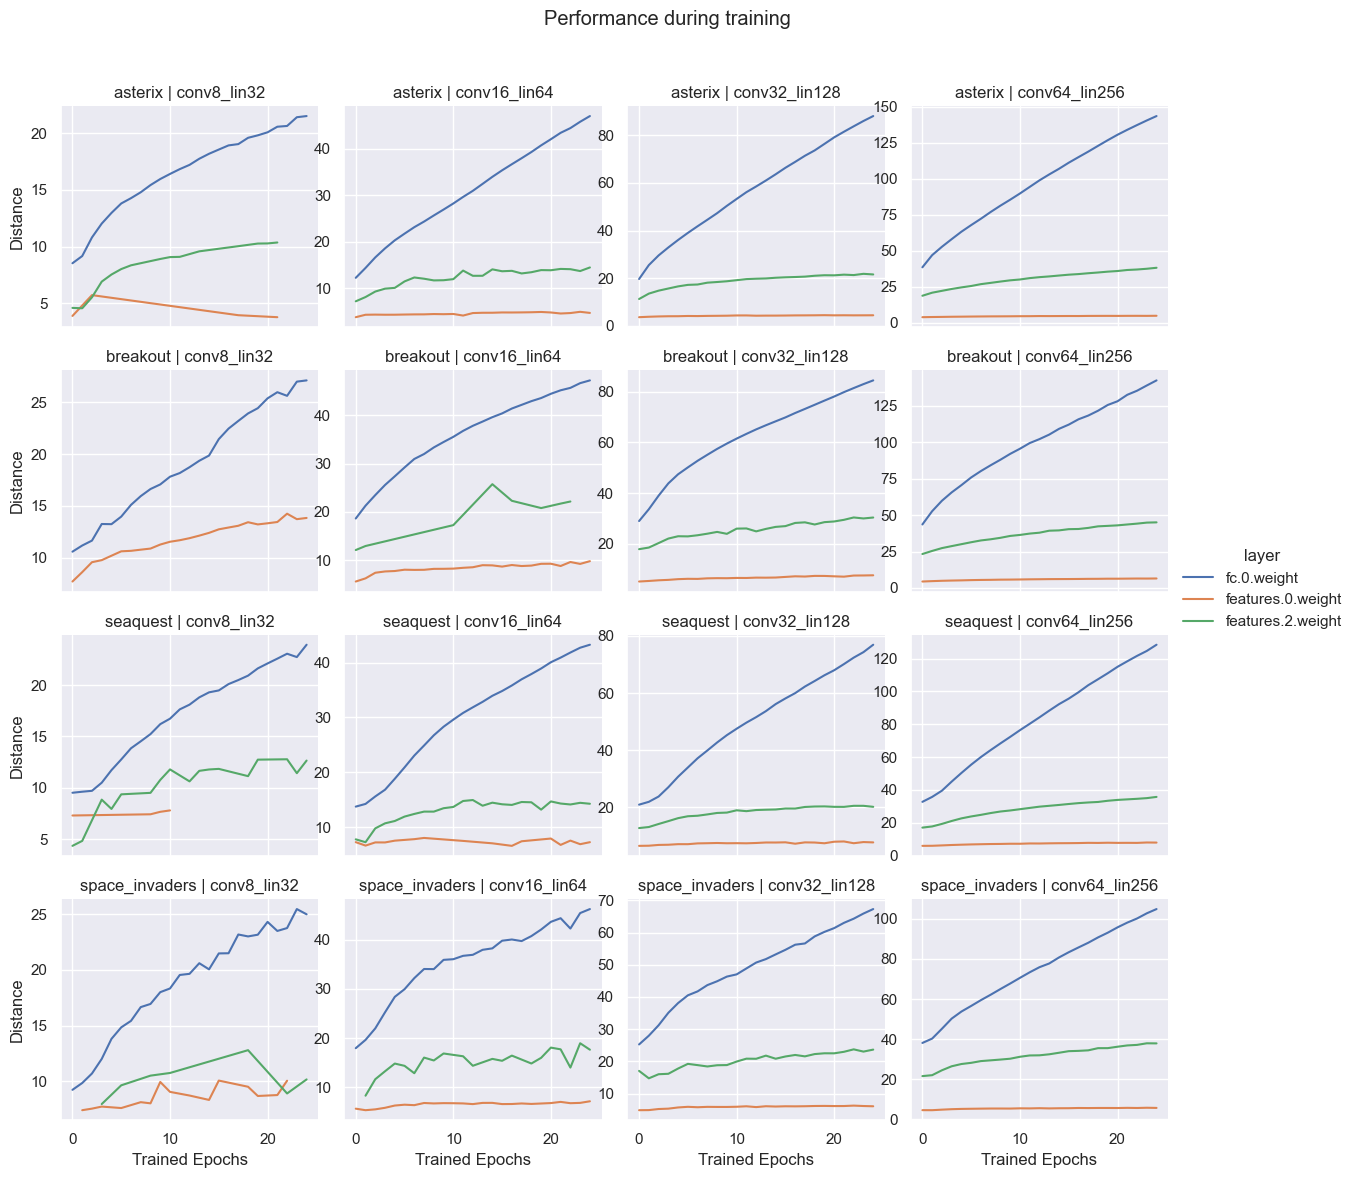

In [50]:
metric_col = 'dead_neuron_l1norms_avg'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(avg_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', metric_col, ax=ax)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', 'Distance')

g.add_legend()

# Show the plot
plt.show()

Text(0.5, 0.98, 'dead_neuron_ratio')

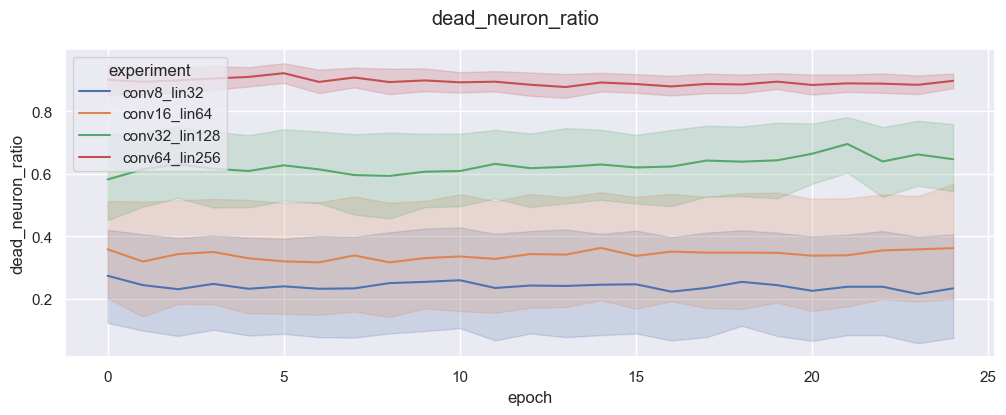

In [51]:
metric_col = 'dead_neuron_ratio'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

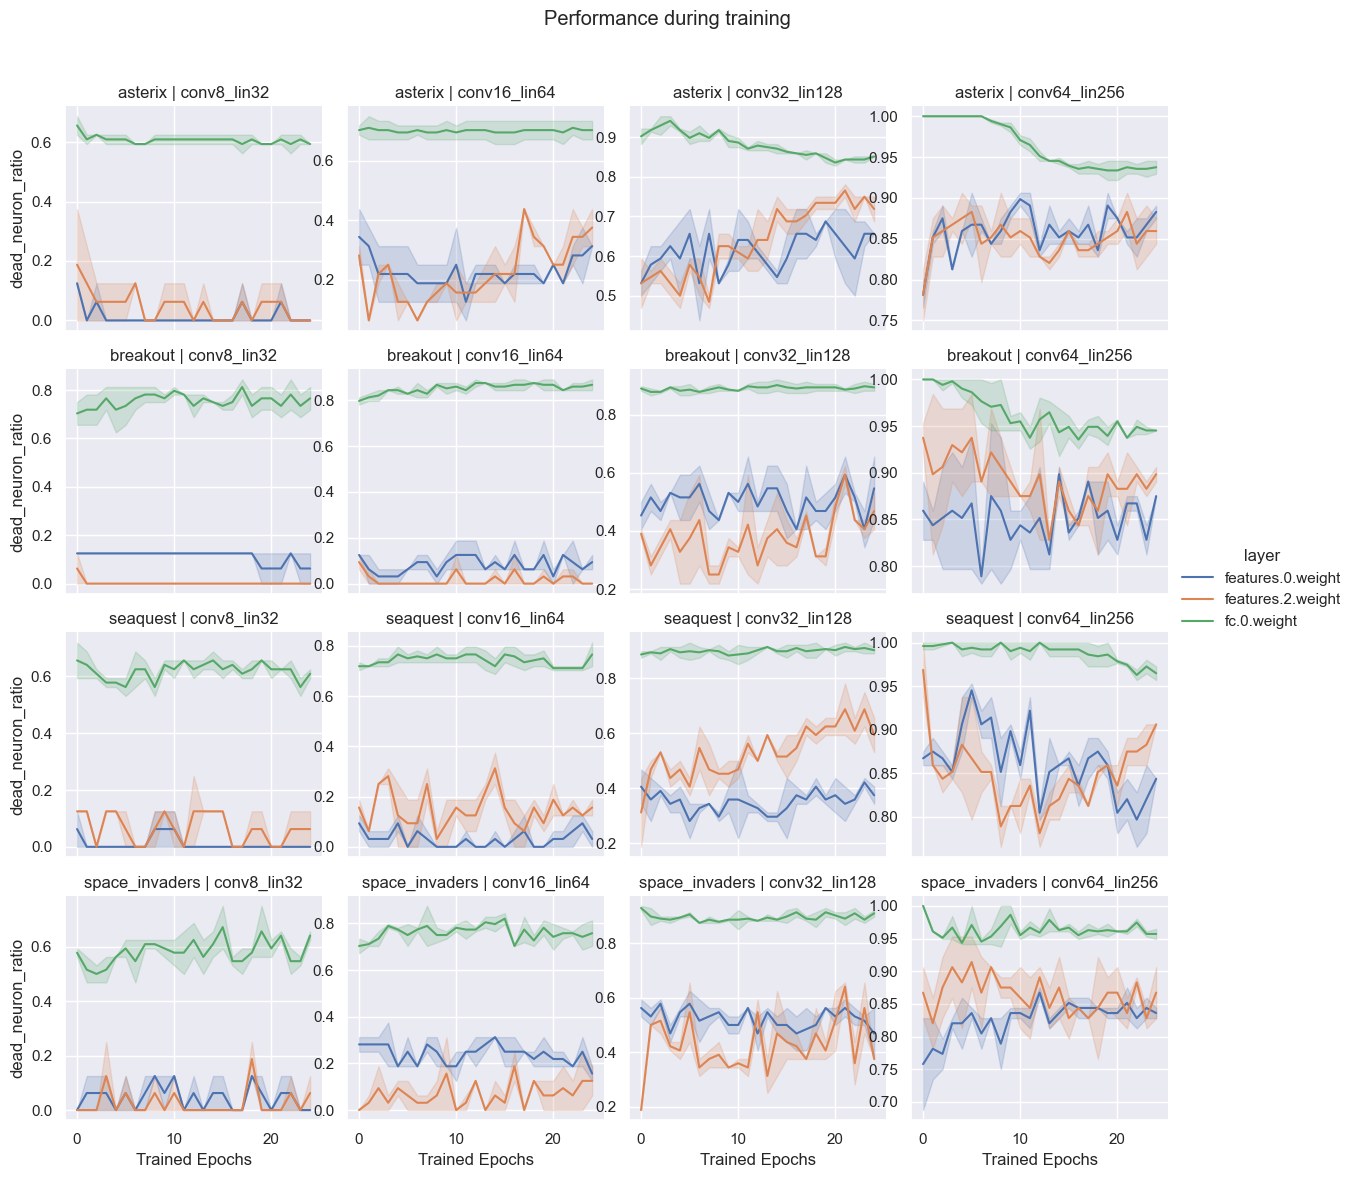

In [52]:
metric_col = 'dead_neuron_ratio'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
# avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(sub_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', metric_col, ax=ax)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', metric_col)

g.add_legend()

# Show the plot
plt.show()

Text(0.5, 0.98, 'redo_l1norm_hamming')

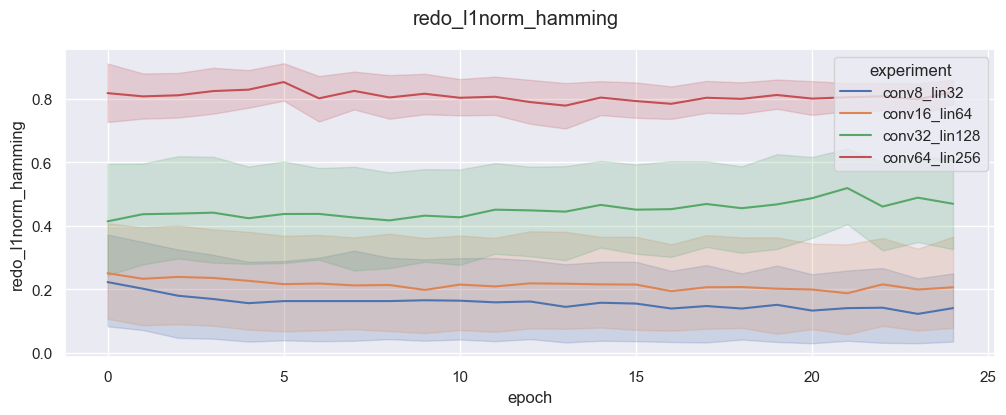

In [53]:
metric_col = 'redo_l1norm_hamming'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

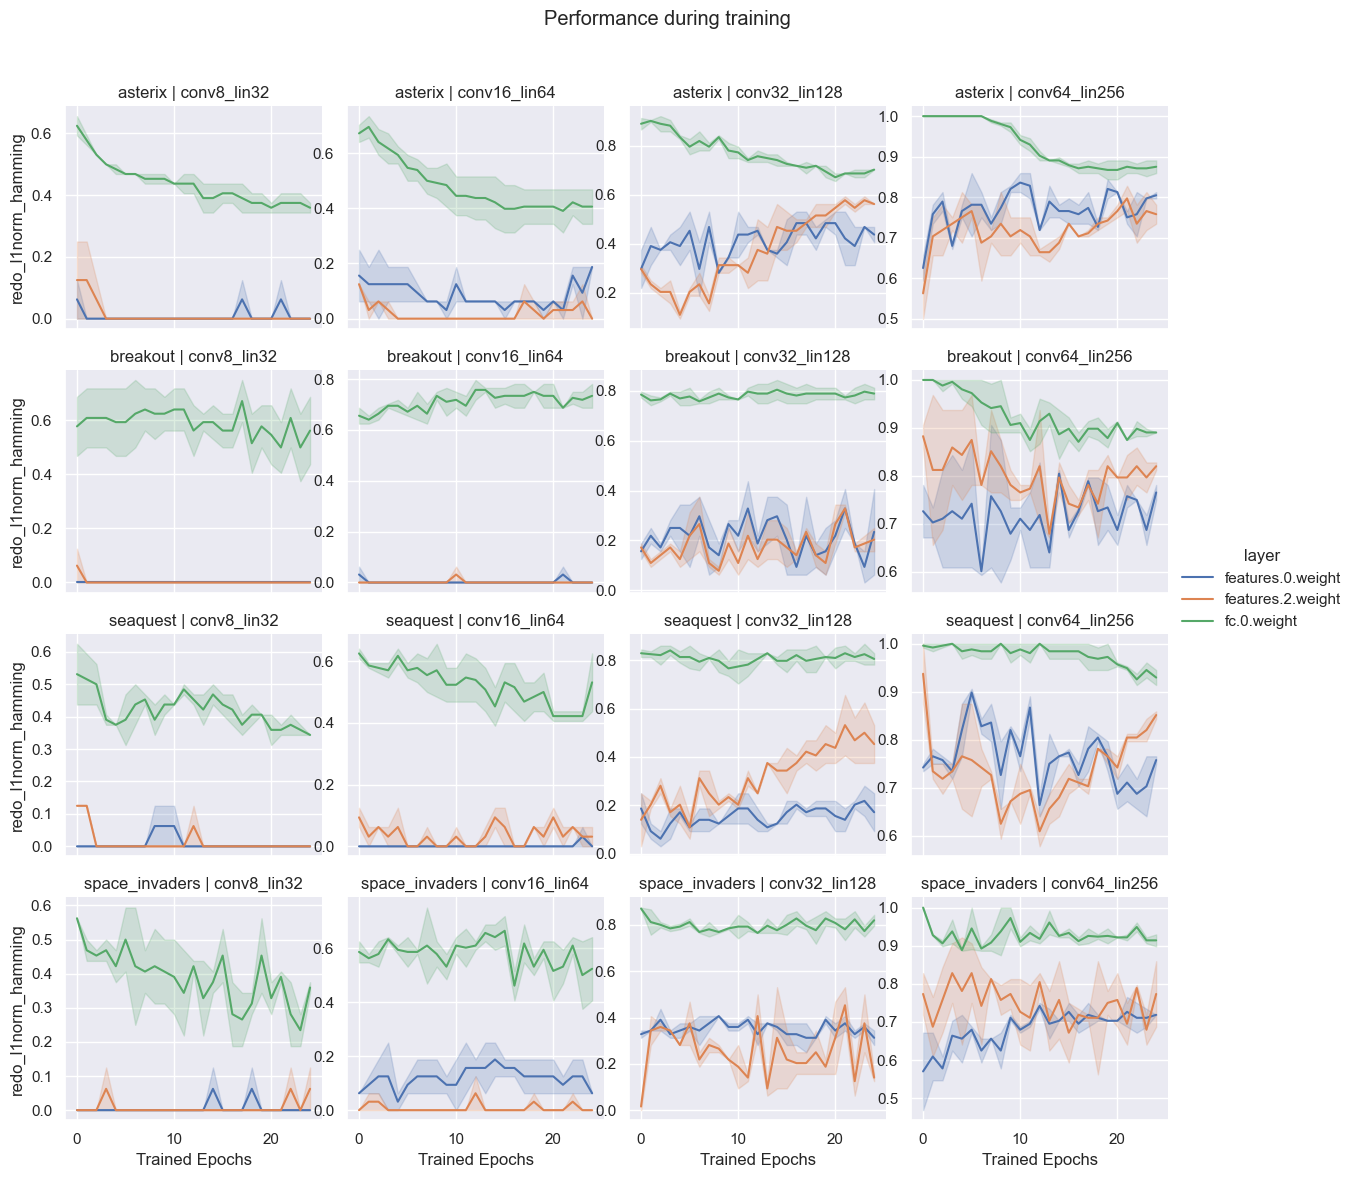

In [54]:
metric_col = 'redo_l1norm_hamming'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
# avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(sub_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', 'redo_l1norm_hamming')

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', metric_col)

g.add_legend()

# Show the plot
plt.show()

In [55]:
df_res.columns

Index(['seed', 'env', 'experiment', 'tau', 'nr_only_redo', 'nr_intersect',
       'nr_only_pruning', 'dead_neuron_l1norms', 'dead_neuron_l1norms_avg',
       'dead_neuron_ratio', 'redo_l1norm_hamming', 'checkpoint', 'epoch',
       'layer', 'kendall_r_corr', 'kendall_r_pval', 'spearman_r_corr',
       'spearman_r_pval', 'pearson_corr', 'pearson_pval'],
      dtype='object')

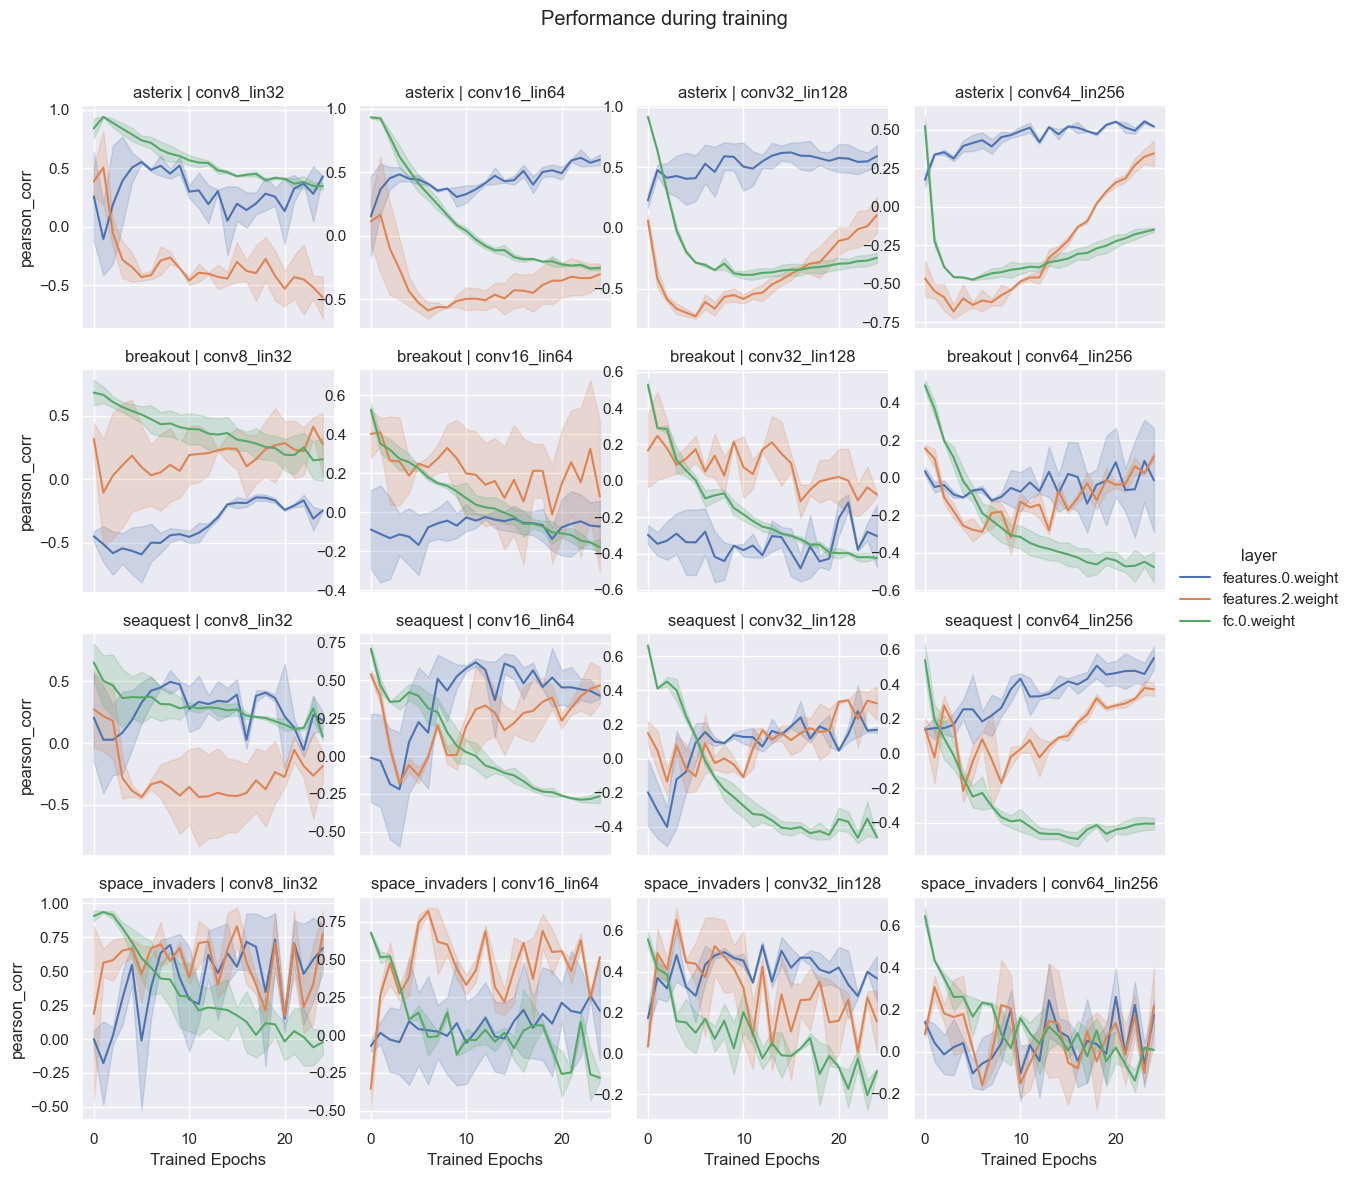

In [56]:
metric_col = 'pearson_corr'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
# avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(sub_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', metric_col)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', metric_col)

g.add_legend()

# Show the plot
plt.show()

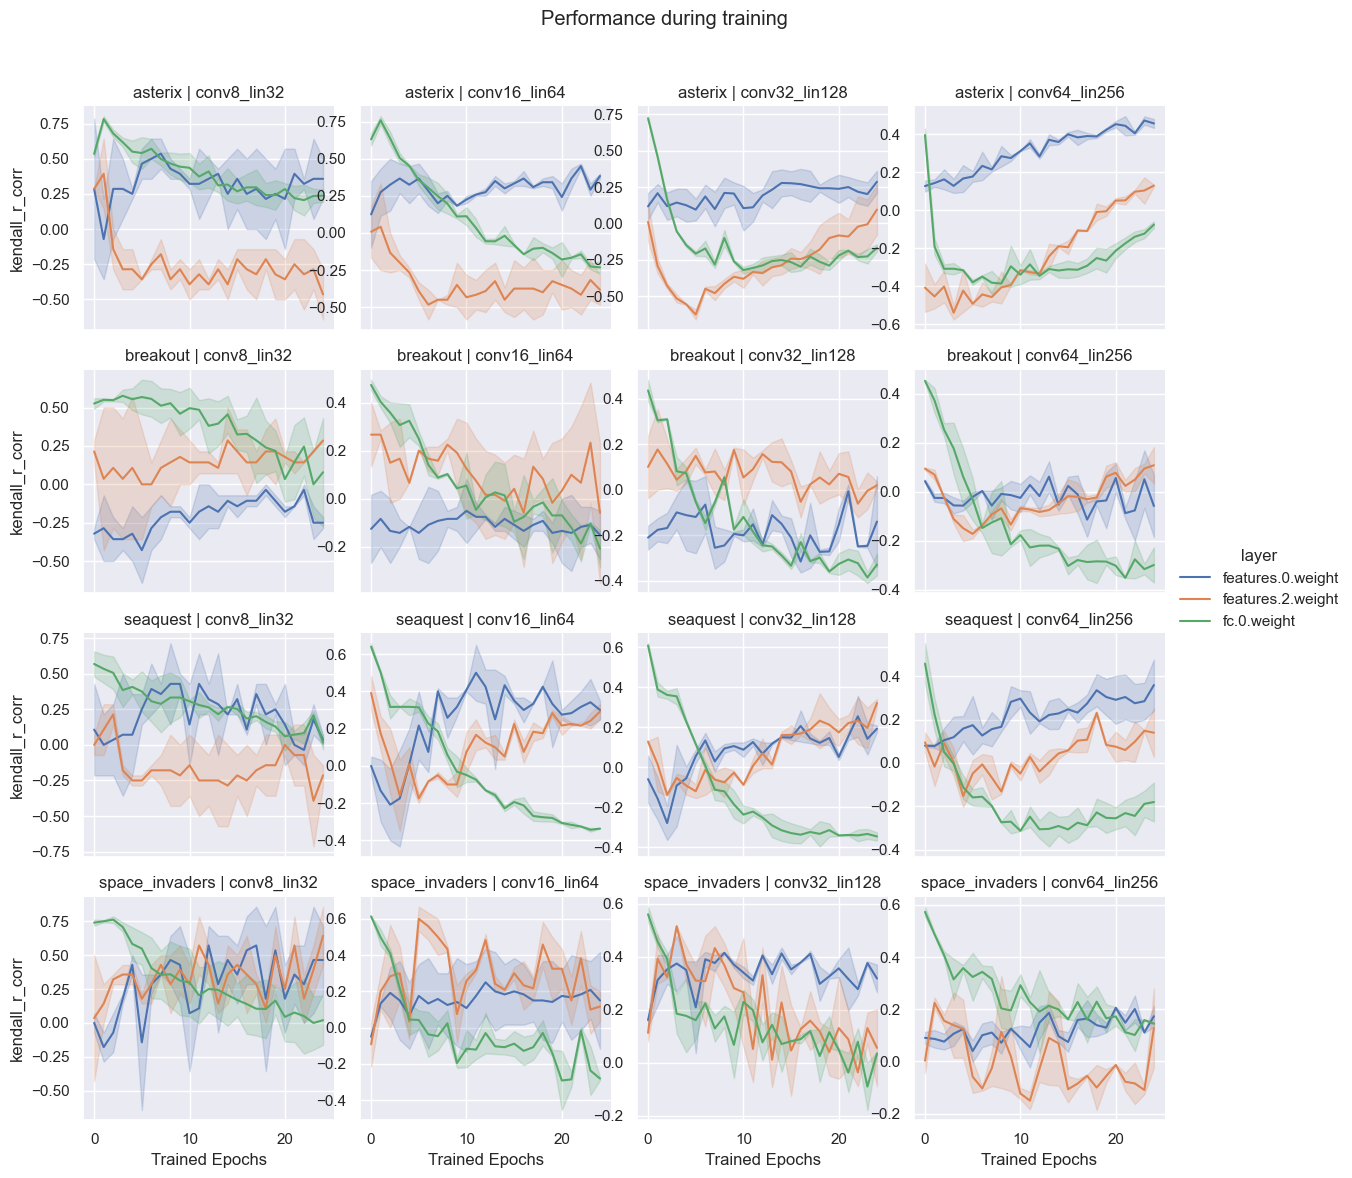

In [57]:
metric_col = 'kendall_r_corr'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
# avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(sub_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', metric_col)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', metric_col)

g.add_legend()

# Show the plot
plt.show()

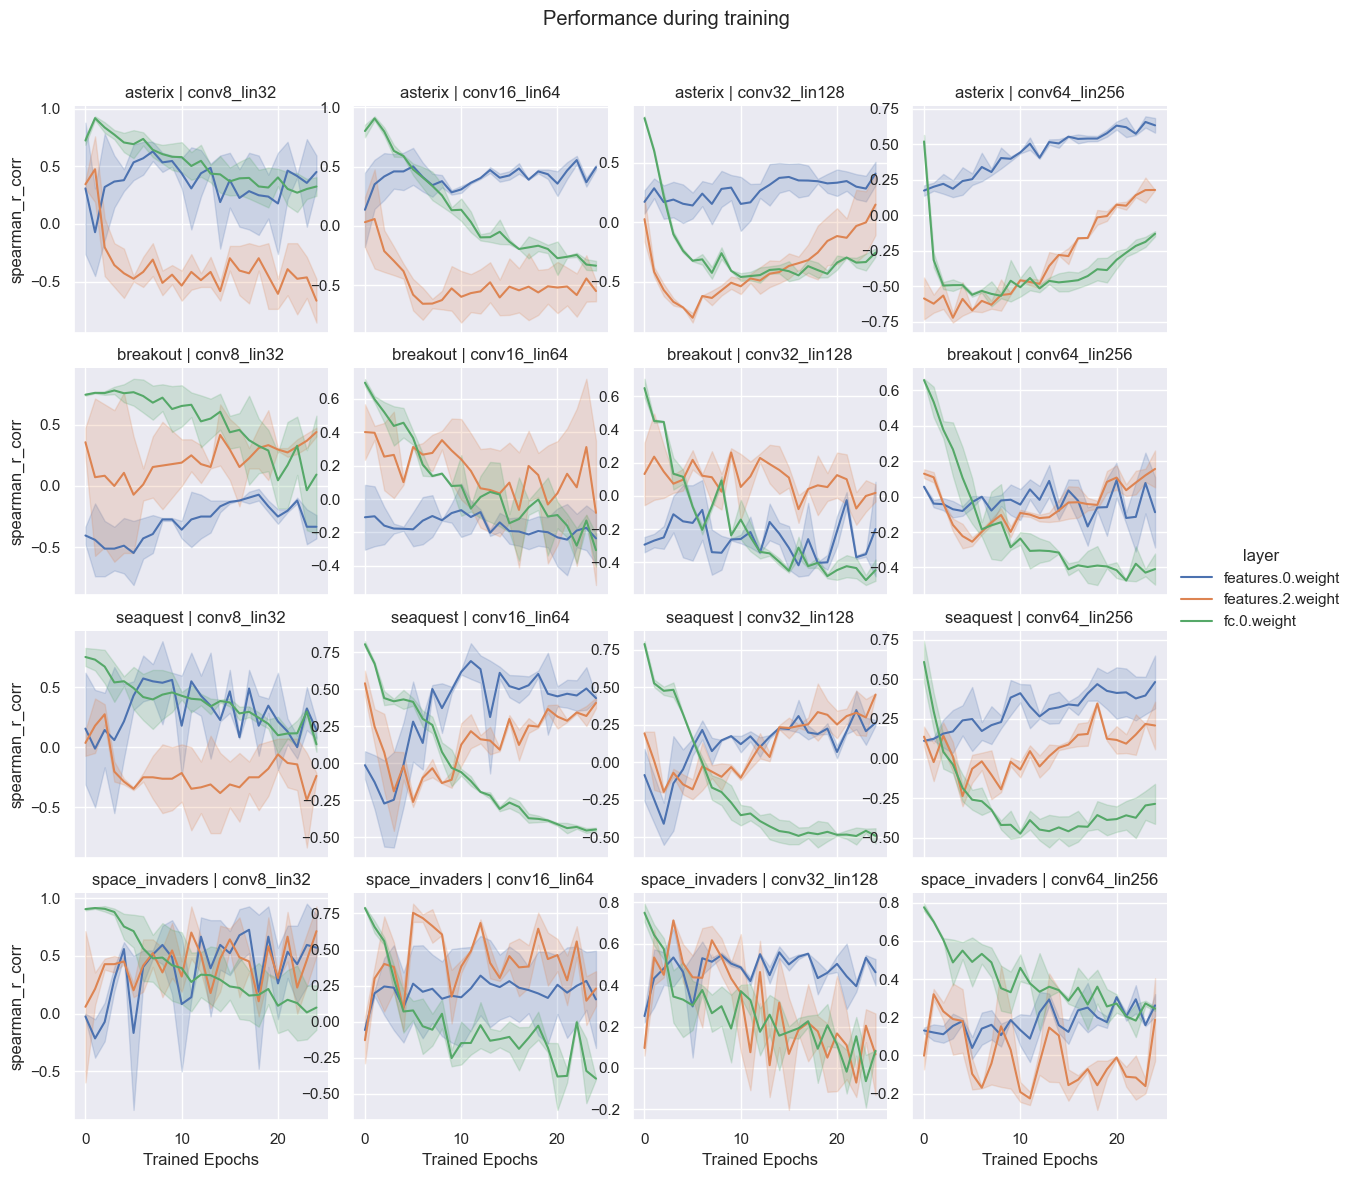

In [58]:
metric_col = 'spearman_r_corr'

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

sub_df = df_res[df_res["tau"] == 0.025]

# Compute the average metric between the seeds for each experiment
# avg_df = sub_df.groupby(['env', 'experiment', 'epoch', "layer"]).mean().reset_index()

g = sns.FacetGrid(sub_df, col_order=experiment_order, row='env', col='experiment', 
height = 3, hue="layer", aspect=1, sharey=False)
g.map(sns.lineplot, 'epoch', metric_col)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=1)

g.figure.subplots_adjust(top=0.9, wspace=0.1)
g.set_axis_labels('Trained Epochs', metric_col)

g.add_legend()

# Show the plot
plt.show()

In [59]:
# TODO: plot:
# at each checkpont 
# stacked barplot with 3 minibars: redo neurons | common neurons | pruning neurons

In [60]:
df_res["layer"].unique()

array(['features.0.weight', 'features.2.weight', 'fc.0.weight'],
      dtype=object)

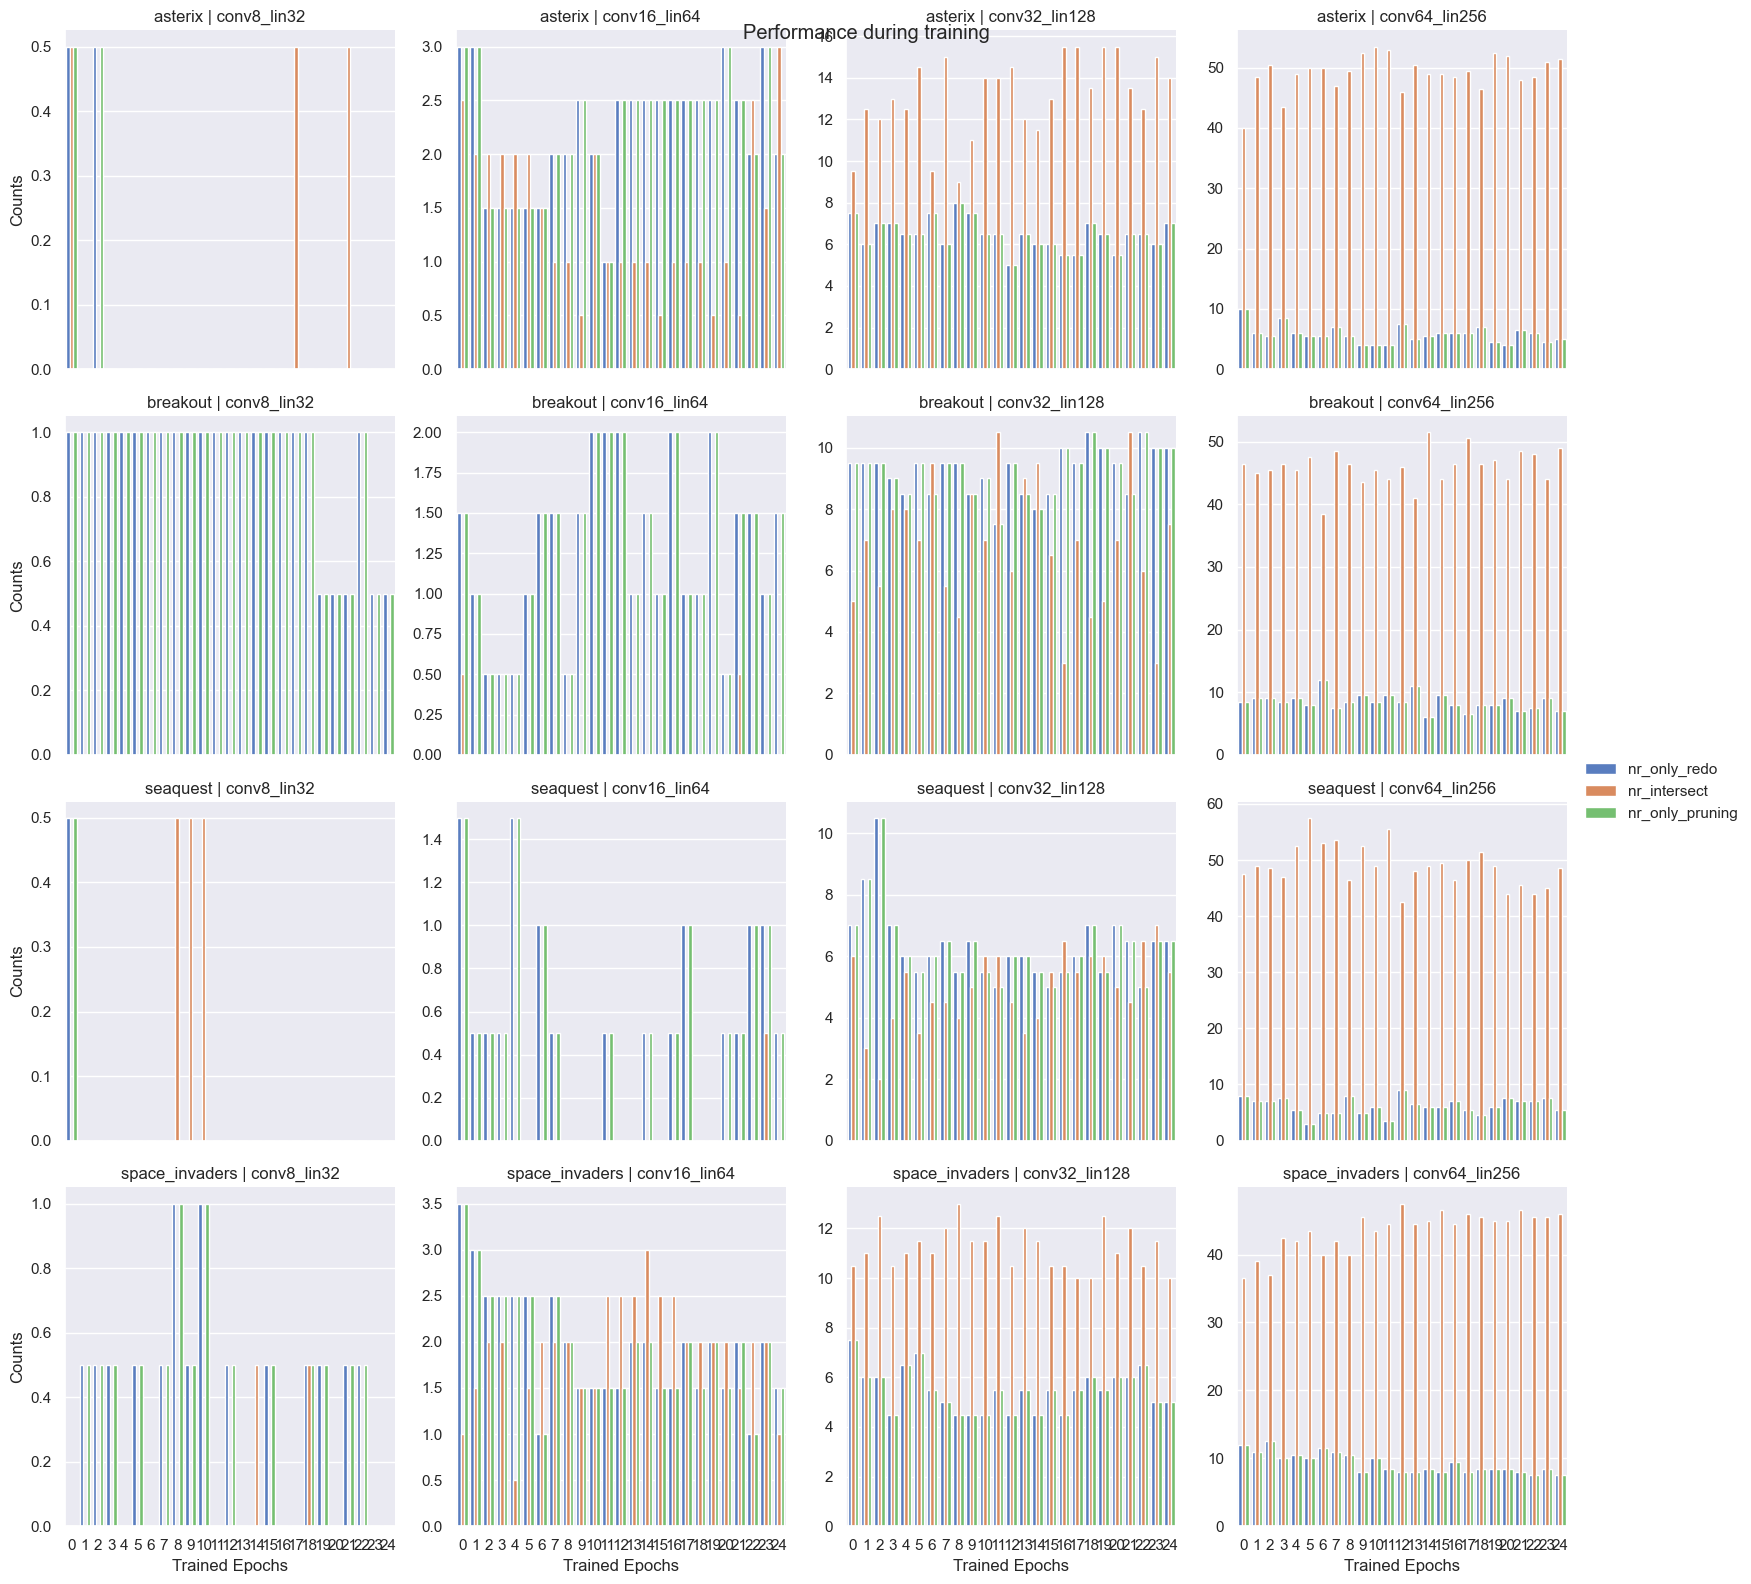

In [61]:
experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']
sub_df = df_res[(df_res["tau"] == 0.025) & (df_res["layer"] == "features.0.weight")]

# Melt the DataFrame to make it long-form
melted_df = sub_df.melt(id_vars=['env', 'experiment', 'epoch'], 
                        value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                        var_name='Category', value_name='Value')

g = sns.FacetGrid(melted_df, col_order=experiment_order, row='env', col='experiment',
                  height=4, aspect=1, sharey=False)

g.map_dataframe(sns.barplot, x='epoch', y='Value', hue='Category', palette='muted', ci=None)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=10)

g.set_axis_labels('Trained Epochs', "Counts")

g.add_legend()

# Show the plot
plt.show()

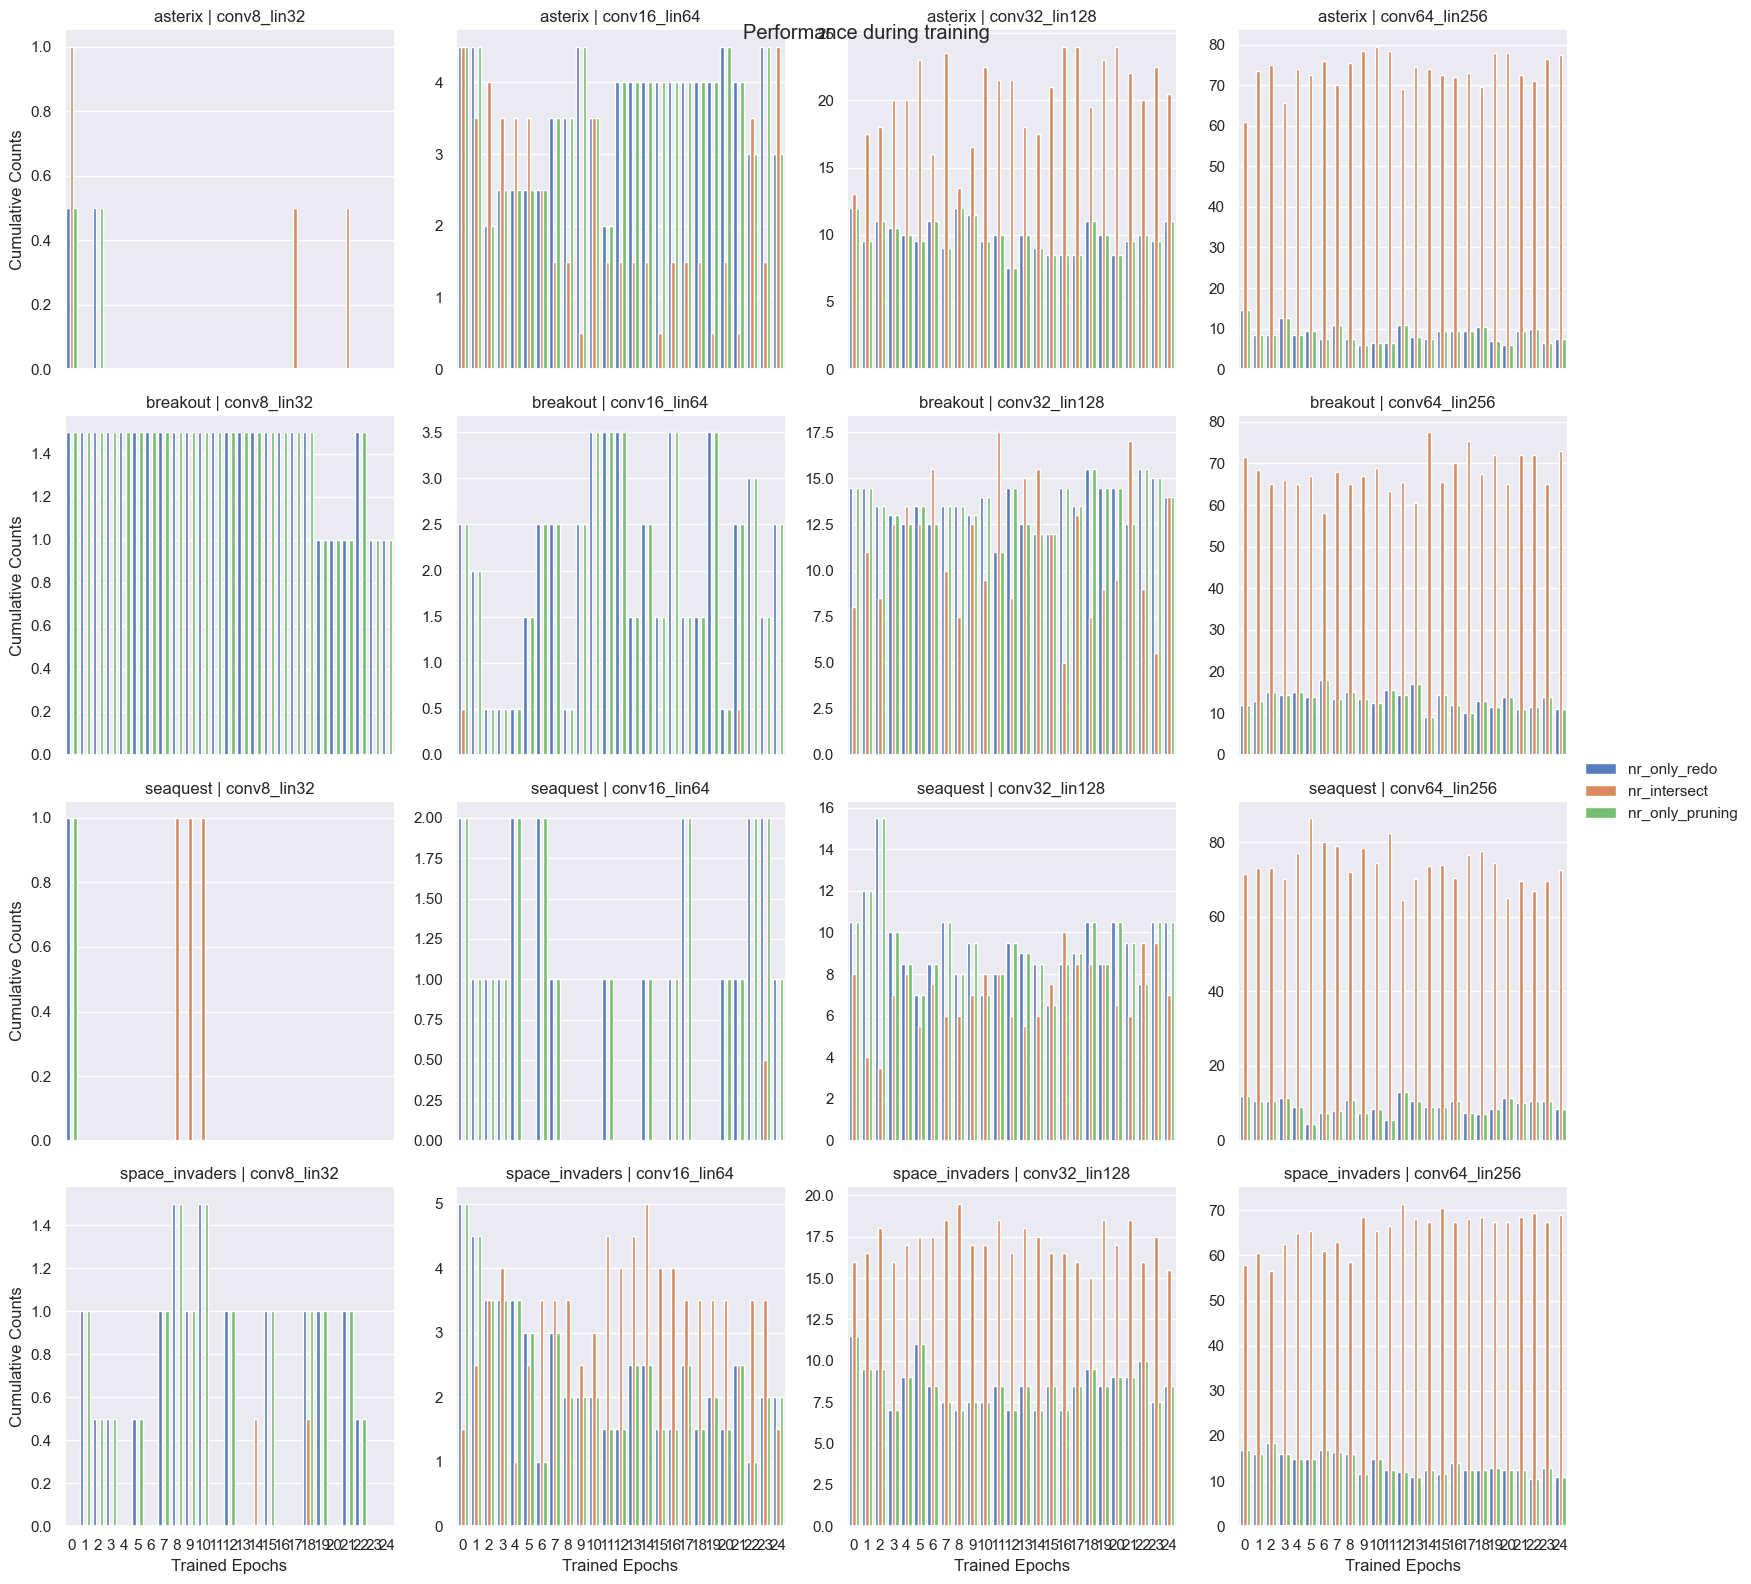

In [62]:
experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']
sub_df = df_res[(df_res["tau"] == 0.025) & (df_res["layer"] == "features.0.weight")]

# Melt the DataFrame to make it long-form
melted_df = sub_df.melt(id_vars=['env', 'experiment', 'epoch'],
                        value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                        var_name='Category', value_name='Value')

# Calculate the cumulative values for each category
melted_df['Cumulative'] = melted_df.groupby(['env', 'experiment', 'epoch', 'Category'])['Value'].transform(np.cumsum)

g = sns.FacetGrid(melted_df, col_order=experiment_order, row='env', col='experiment',
                  height=4, aspect=1, sharey=False)

# Use sns.barplot with cumulative values as the heights
g.map_dataframe(sns.barplot, x='epoch', y='Cumulative', hue='Category', palette='muted', ci=None)

g.fig.suptitle('Performance during training')
g.set_titles(row_template='{row_name}', col_template='{col_name}', fontsize=10)

g.set_axis_labels('Trained Epochs', 'Cumulative Counts')

g.add_legend()

# Show the plot
plt.show()

In [63]:

experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

for layer in df_res["layer"].unique():
    sub_df = df_res[(df_res["tau"] == 0.025) & (df_res["layer"] == layer)]

    melted_df = sub_df.melt(id_vars=['env', 'experiment', 'epoch'],
                            value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                            var_name='Category', value_name='Value')

    fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment",
                category_orders={"experiment": experiment_order}, 
                height=600)
    
    title = f"Redo and Norm overlap - Layer {layer} shared Y"
    file_path = f"imgs/{title}.png"

    # Save the figure as a PNG image
    pio.write_image(fig, file_path)

    fig.update_layout(title=title)
    fig.show()


    melted_df = sub_df.melt(id_vars=['env', 'experiment', 'epoch'],
                            value_vars=['nr_only_redo', 'nr_intersect', 'nr_only_pruning'],
                            var_name='Category', value_name='Value')

    fig = px.bar(melted_df, x="epoch", y="Value", color="Category", facet_row="env", facet_col="experiment",
                category_orders={"experiment": experiment_order}, height=600)

    fig.update_yaxes(matches=None, showticklabels=True)

    title = f"Redo and Norm overlap - Layer {layer}"
    file_path = f"imgs/{title}.png"
    
    # Save the figure as a PNG image
    pio.write_image(fig, file_path)

    fig.update_layout(title=title)

    fig.show()

In [64]:
melted_df

env    experiment  epoch         Category  Value
0            asterix  conv16_lin64      0     nr_only_redo      1
1            asterix  conv16_lin64      9     nr_only_redo     11
2            asterix  conv16_lin64     10     nr_only_redo     13
3            asterix  conv16_lin64     11     nr_only_redo     14
4            asterix  conv16_lin64     12     nr_only_redo     14
...              ...           ...    ...              ...    ...
2395  space_invaders   conv8_lin32      4  nr_only_pruning      3
2396  space_invaders   conv8_lin32      5  nr_only_pruning      1
2397  space_invaders   conv8_lin32      6  nr_only_pruning      1
2398  space_invaders   conv8_lin32      7  nr_only_pruning      4
2399  space_invaders   conv8_lin32      8  nr_only_pruning      3

[2400 rows x 5 columns]